### "Simplification" attemps with OSMnx

For test (continents) cities [FUA ID]:
* (Africa) Douala [809]
* (Asia) Aleppo [1133]
* (South America) Bucaramanga [4617]
* (North America) Salt Lake City [4881]
* (Europe) Amsterdam [1427] (or Liège? - if we want a smaller city)
* (Oceania) Auckland [869]

In [1]:
# import libraries
import geopandas as gpd
import pandas as pd
import osmnx as ox
import networkx as nx
import momepy
import shapely
from collections import Counter
from shapely.ops import linemerge
from shapely.geometry import LineString
import numpy as np
import matplotlib.pyplot as plt
import esda

**Read in meta data**

In [2]:
# read in sample metadata
sample = gpd.read_parquet("../data/sample.parquet")
sample.head(2)

eFUA_ID  UC_num                               UC_IDs  eFUA_name  \
305   9129.0     1.0                                 8078      Gonda   
91    7578.0     6.0  10577;10581;10583;10596;10605;10607  Chongqing   

     Commuting Cntry_ISO Cntry_name  FUA_area  UC_area    FUA_p_2015  \
305        1.0       IND      India      66.0     29.0  1.074100e+06   
91         1.0       CHN      China    2267.0    618.0  6.036834e+06   

        UC_p_2015     Com_p_2015  \
305  1.066419e+06    7680.678101   
91   5.157726e+06  879107.861057   

                                              geometry continent iso_a3  
305  POLYGON ((81.98398 27.19657, 81.99471 27.19657...      Asia    IND  
91   POLYGON ((106.23972 29.52328, 106.19622 29.523...      Asia    CHN

In [3]:
# dict of fua ID : cityname
citydict = {
    809: "Douala",
    1133: "Aleppo",
    4617: "Bucaramanga",
    4881: "Salt Lake City",
    1427: "Amsterdam",
    869: "Auckland"
}

**Read in data for example city**

In [4]:
# read in data for example city: Amsterdam
fua = 1427
gdf = gpd.read_parquet(f"../data/{fua}/roads_osm.parquet")
gdf = gdf[["highway", "geometry"]]
gdf = gdf.reset_index(drop=True)
G = momepy.gdf_to_nx(
    gdf_network=gdf, 
    approach="primal",
    directed=True,
    osmnx_like=True)

**Remove multi edges (with key >0)**

In [5]:
multiedges = []
for edge in G.edges:
    if edge[2]>0:
        multiedges.append(edge)
G.remove_edges_from(multiedges)
print(f"{len(multiedges)} multiedges removed")

567 multiedges removed


**Consolidate & simplify & find face artifacts**

In [6]:
# check crs, needs to be a projected one
G.graph["crs"]

<Projected CRS: {"$schema": "https://proj.org/schemas/v0.5/projjso ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 31N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

initialize gdict & define tolerance thresholds to compare:

In [7]:
gdict = {}
tolerances = [1,5,10,15,20]

for each tolerance threshold `tol`,
* consolidate intersections
* simplify graph
* generate edge gdf
* find face artifacts
* save all res to `gdict[tol]`

In [8]:
for tol in tolerances:
    print(f"Tolerance {tol}")
    gdict[tol] = {}
    print("\t consolidating...")
    gdict[tol]["cons"] = ox.consolidate_intersections(
        G=G, 
        tolerance=tol, 
        rebuild_graph=True,
        dead_ends=True,
        reconnect_edges=True)
    print("\t simplifying...")
    gdict[tol]["simp"] = ox.simplify_graph(gdict[tol]["cons"])
    print("\t finding edges...")
    gdict[tol]["simp_edges"] = ox.graph_to_gdfs(
        gdict[tol]["simp"],
        nodes=False,
        edges=True,
        fill_edge_geometry=False
        )
    print("\t finding face artifacts...")
    gdict[tol]["fa"] = momepy.FaceArtifacts(
        gdict[tol]["simp_edges"]
        )

Tolerance 1
	 consolidating...
	 simplifying...
	 finding edges...
	 finding face artifacts...
Tolerance 5
	 consolidating...
	 simplifying...
	 finding edges...
	 finding face artifacts...
Tolerance 10
	 consolidating...
	 simplifying...
	 finding edges...
	 finding face artifacts...
Tolerance 15
	 consolidating...
	 simplifying...
	 finding edges...
	 finding face artifacts...


/var/folders/66/3jkth_7d5gggg6pyr8yywwt40000gn/T/ipykernel_72962/2348646756.py:21: UserWarning: No threshold found. Either your dataset it too small or the distribution of the face artifact index does not follow the expected shape.
  gdict[tol]["fa"] = momepy.FaceArtifacts(


Tolerance 20
	 consolidating...
	 simplifying...
	 finding edges...
	 finding face artifacts...


**Compare network degree histograms**

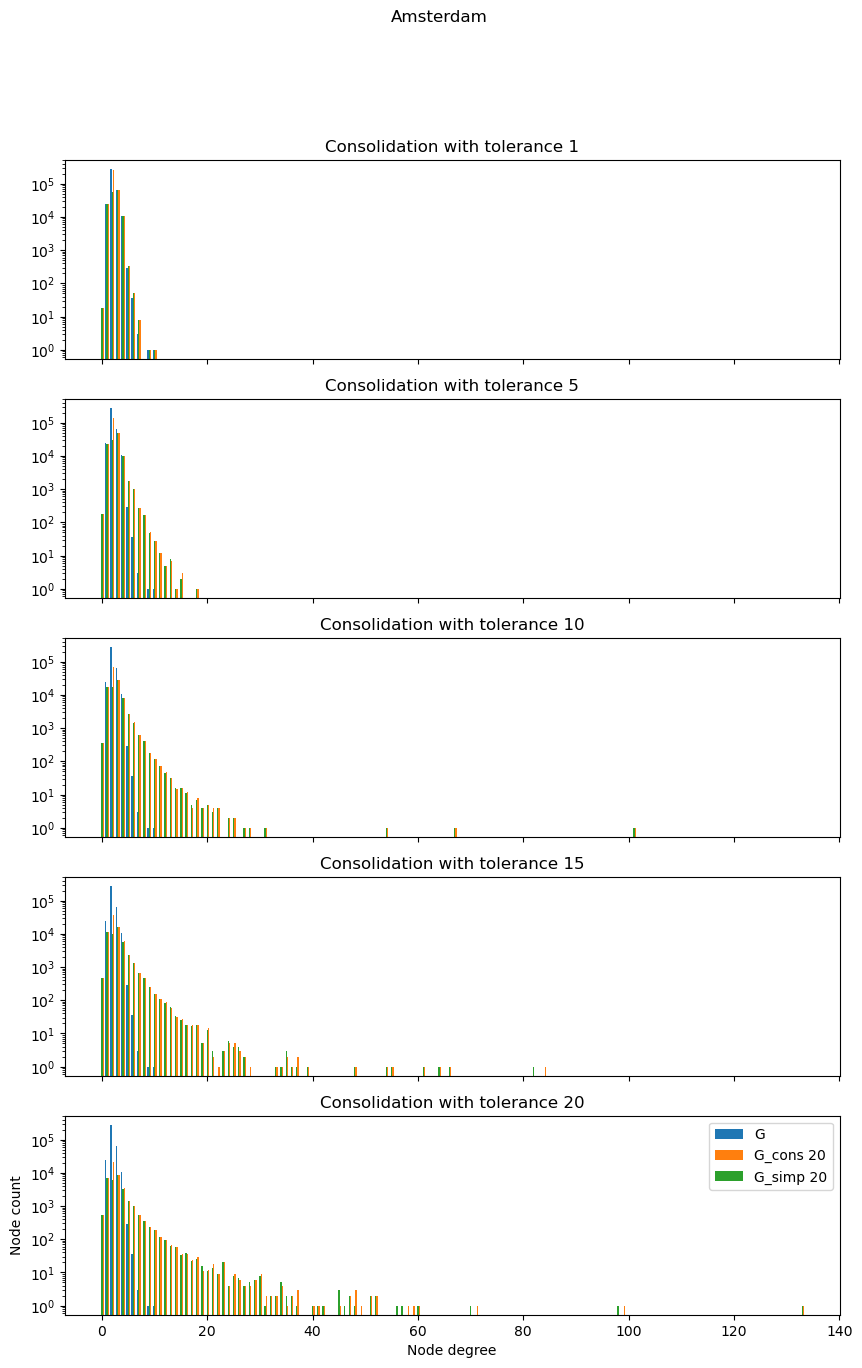

In [20]:
fig, ax = plt.subplots(5,1, sharex=True, sharey=True, figsize = (10,15))

dh_base = nx.degree_histogram(G)

for i in range(len(tolerances)):
    tol = tolerances[i]
    ax[i].bar(x = [i-0.25 for i in range(len(dh_base))], height = dh_base, width = 0.25, label = "G")
    dh = nx.degree_histogram(gdict[tol]["cons"])
    ax[i].bar(x = [i + 0.25 for i in range(len(dh))], height = dh, width = 0.25, zorder = 2, label = f"G_cons {tol}")

    dh = nx.degree_histogram(gdict[tol]["simp"])
    ax[i].bar(x = range(len(dh)), height = dh, width = 0.25, zorder = 1, label = f"G_simp {tol}")
    ax[i].set_title(f"Consolidation with tolerance {tol}")

plt.yscale("log")
plt.legend()
plt.xlabel("Node degree")
plt.ylabel("Node count")
#plt.xticks(ticks = range(21), labels = range(21))
plt.suptitle(citydict[fua])
plt.show()

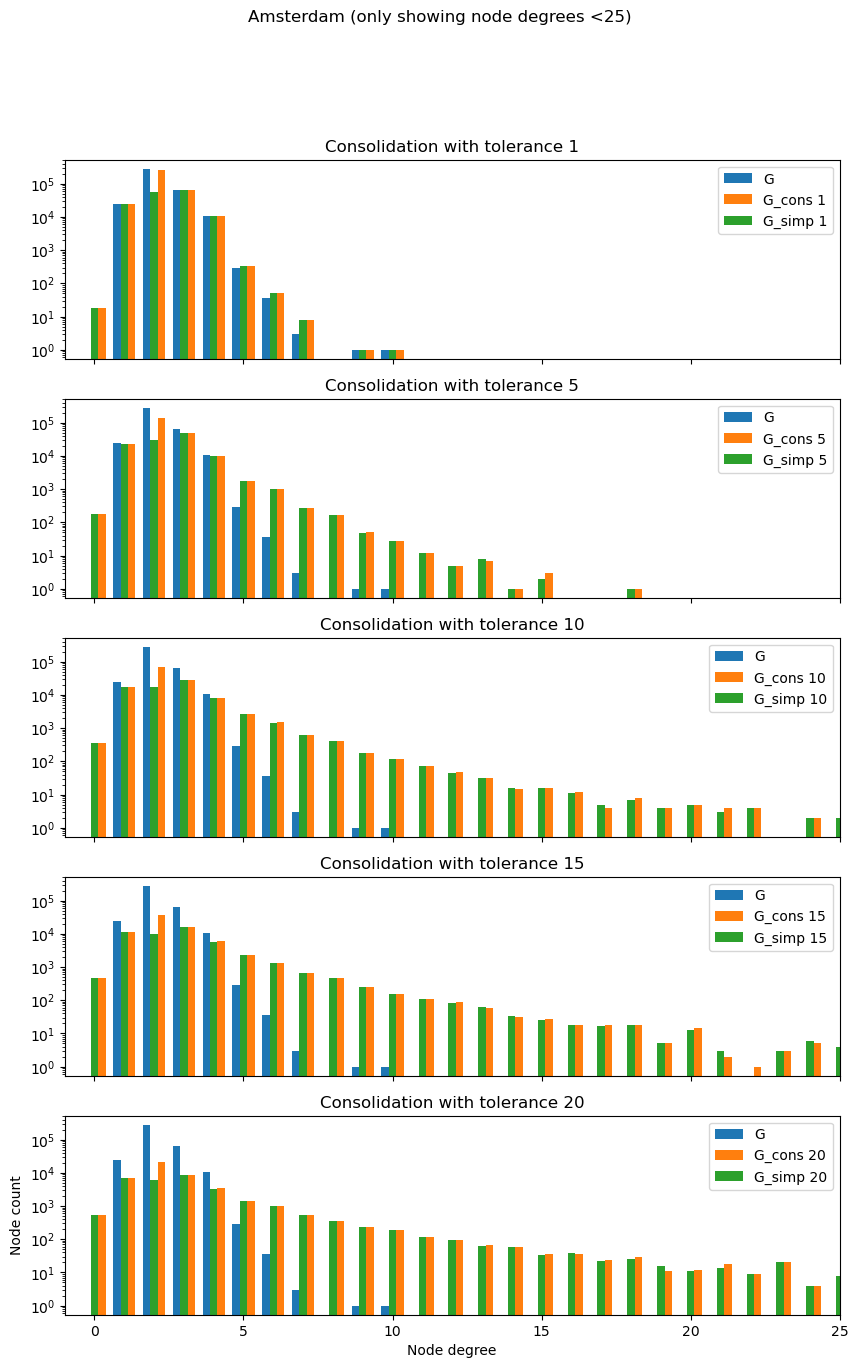

In [25]:
fig, ax = plt.subplots(5,1, sharex=True, sharey=True, figsize = (10,15))

dh_base = nx.degree_histogram(G)

for i in range(len(tolerances)):
    
    ax[i].bar(x = [i-0.25 for i in range(len(dh_base))], height = dh_base, width = 0.25, label = "G")
    
    tol = tolerances[i]
    dh = nx.degree_histogram(gdict[tol]["cons"])
    ax[i].bar(x = [i + 0.25 for i in range(len(dh))], height = dh, width = 0.25, zorder = 2, label = f"G_cons {tol}")

    dh = nx.degree_histogram(gdict[tol]["simp"])
    ax[i].bar(x = range(len(dh)), height = dh, width = 0.25, zorder = 1, label = f"G_simp {tol}")
    ax[i].set_title(f"Consolidation with tolerance {tol}")

    ax[i].legend()

plt.yscale("log")
plt.xlabel("Node degree")
plt.ylabel("Node count")
plt.xlim([-1,25])
plt.suptitle(citydict[fua] + " (only showing node degrees <25)")
plt.show()

Adding base case to gdict:

In [63]:
gdict[5].keys()

dict_keys(['cons', 'simp', 'simp_edges', 'fa'])

In [65]:
G_simp = ox.simplify_graph(G)

gdict[0] = {}

gdict[0]["simp_edges"] = ox.graph_to_gdfs(
    G = G_simp, 
    nodes = False, 
    edges = True
    )

gdict[0]["fa"] = momepy.FaceArtifacts(gdict[0]["simp_edges"])

**Compare face artifact count and area**

In [66]:
# print artifact count and area
def get_artifact_metrics(face_artifacts):
    '''
    input: momepy.FaceArtifact class
    returns: count and total area of face artifacts
    '''
    if face_artifacts is None:
        raise ValueError(
            "No face artifacts found."
        )
    return len(face_artifacts), face_artifacts.area.sum() / 10**6

for tol in [0] + tolerances:
    print(f"tol {tol}")
    try:
        print(get_artifact_metrics(gdict[tol]["fa"].face_artifacts))
    except:
        print("no FA found")

tol 0
(16956, 22.331132846286046)
tol 1
(17347, 22.980196056879855)
tol 5
(18136, 21.713149630369507)
tol 10
(18547, 16.43647923898789)
tol 15
no FA found
tol 20
(13028, 14.128760662430901)


In [67]:
# save for qgis exploration
for tol in [0] + tolerances:
    gdict[tol]["simp_edges"][["geometry"]].to_file(f"./temp/edges{tol}.gpkg", index = None)
    try:
        gdict[tol]["fa"].face_artifacts[["geometry"]].to_file(f"./temp/artifacts{tol}.gpkg", index = None)
    except:
        pass

### Explore edges & face artifacts after consolidating intersections

In [62]:
tol = 20
gdict[tol]["fa"].face_artifacts.explore()

**Try to first simplify, then consolidate**

In [68]:
simpdict = {}

for tol in tolerances:
    simpdict[tol] = {}
    print(f"tolerace {tol}")
    print("\t consolidating...")
    simpdict[tol]["cons"] = ox.consolidate_intersections(
        G=G_simp,
        tolerance=tol,
        rebuild_graph=True,
        dead_ends=True,
        reconnect_edges=True
    )
    print("\t generating edges...")
    simpdict[tol]["cons_edges"] = ox.graph_to_gdfs(
        G=simpdict[tol]["cons"],
        nodes=False,
        edges=True
    )
    print("\t computing face artifacts")
    simpdict[tol]["fa"] = momepy.FaceArtifacts(simpdict[tol]["cons_edges"])

tolerace 1
	 consolidating...
	 generating edges...
	 computing face artifacts
tolerace 5
	 consolidating...
	 generating edges...
	 computing face artifacts
tolerace 10
	 consolidating...
	 generating edges...
	 computing face artifacts
tolerace 15
	 consolidating...
	 generating edges...
	 computing face artifacts
tolerace 20
	 consolidating...
	 generating edges...
	 computing face artifacts


In [69]:
# save for qgis exploration
for tol in tolerances:
    simpdict[tol]["cons_edges"][["geometry"]].to_file(f"./temp/edges{tol}simp.gpkg", index = None)
    try:
        simpdict[tol]["fa"].face_artifacts[["geometry"]].to_file(f"./temp/artifacts{tol}simp.gpkg", index = None)
    except:
        pass

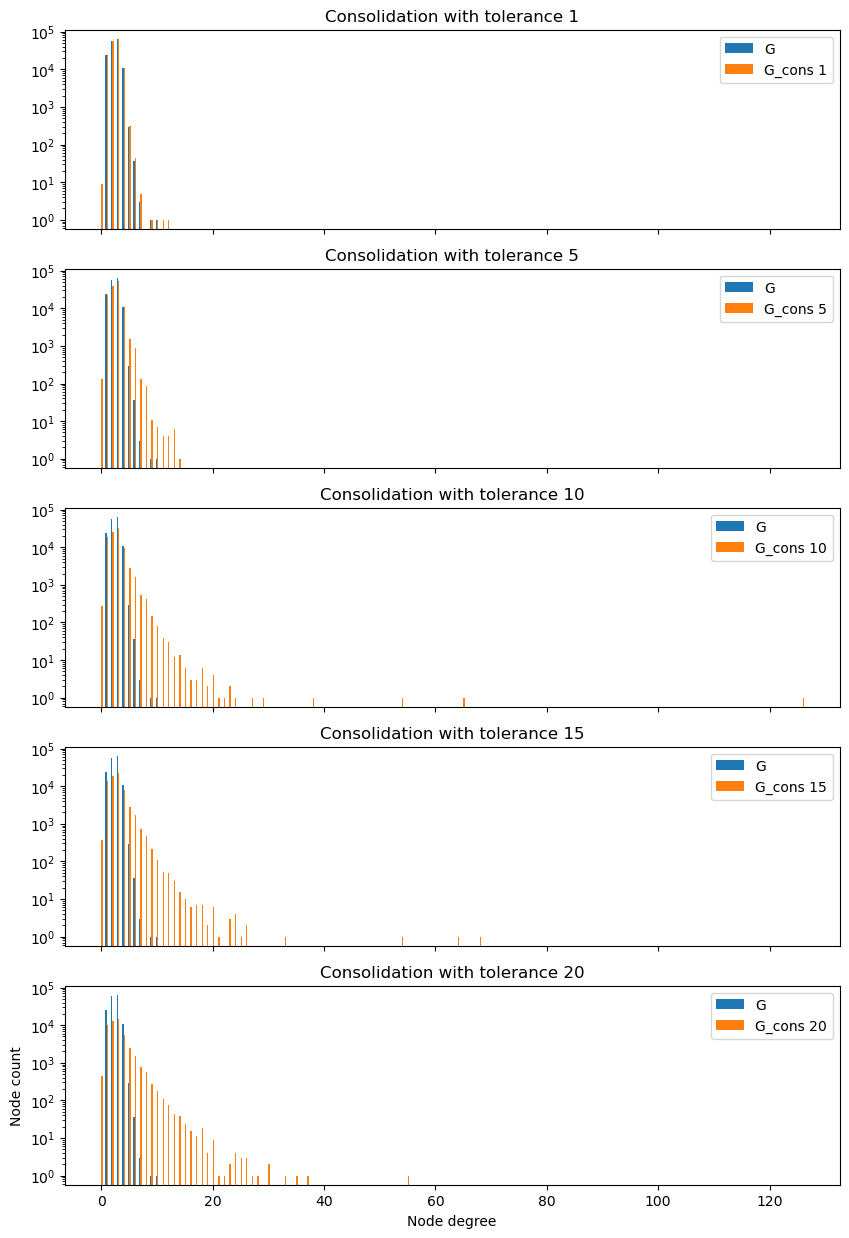

In [71]:
fig, ax = plt.subplots(5,1, sharex=True, sharey=True, figsize = (10,15))

dh_base = nx.degree_histogram(G_simp)

for i in range(len(tolerances)):
    
    ax[i].bar(x = [i-0.125 for i in range(len(dh_base))], height = dh_base, width = 0.25, label = "G")
    
    tol = tolerances[i]

    dh = nx.degree_histogram(simpdict[tol]["cons"])
    ax[i].bar(x = [i + 0.125 for i in range(len(dh))], height = dh, width = 0.25, zorder = 2, label = f"G_cons {tol}")

    ax[i].set_title(f"Consolidation with tolerance {tol}")

    ax[i].legend()

plt.yscale("log")
plt.xlabel("Node degree")
plt.ylabel("Node count")
#plt.xlim([-1,25])
#plt.suptitle(citydict[fua] + " (only showing node degrees <25)")
plt.show()

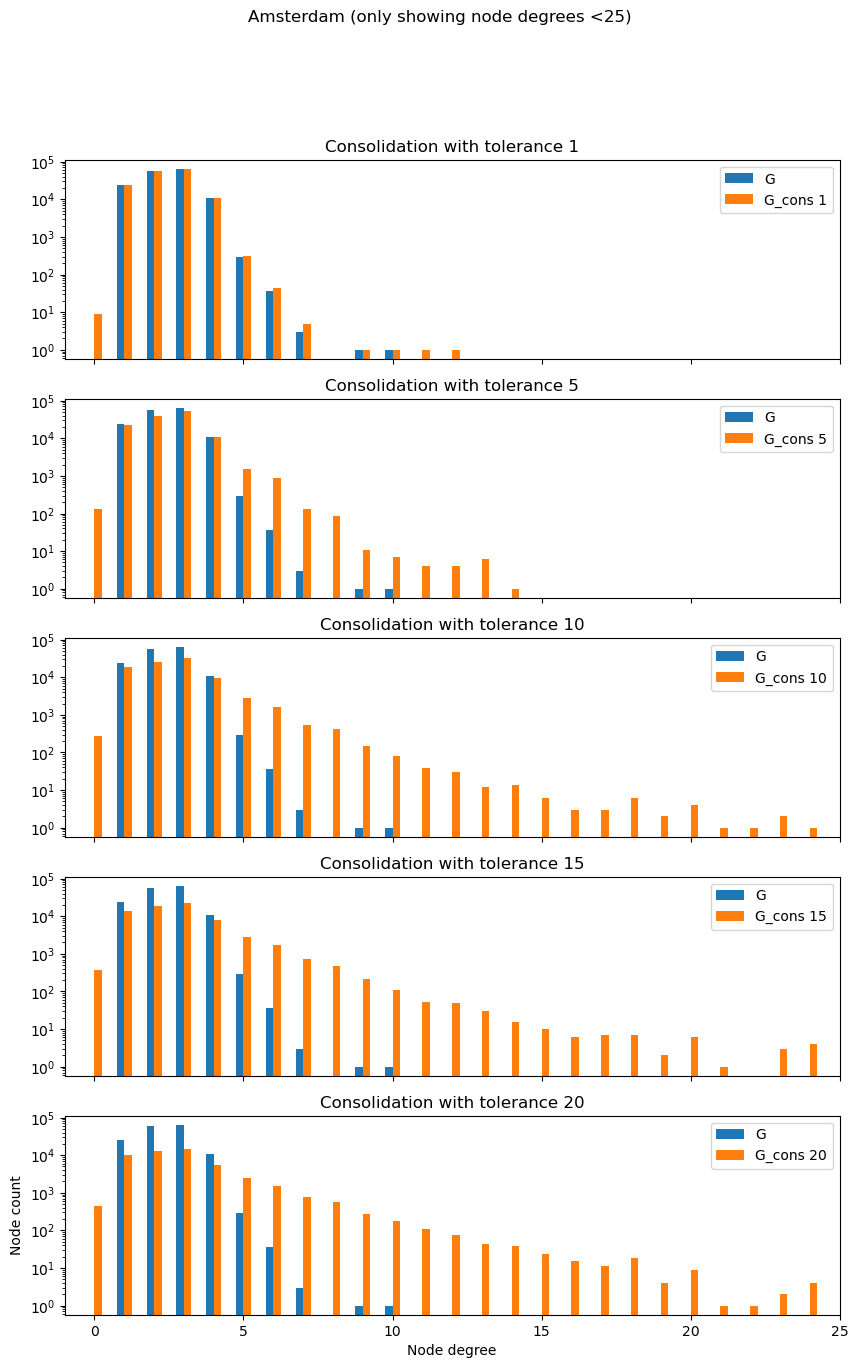

In [72]:
fig, ax = plt.subplots(5,1, sharex=True, sharey=True, figsize = (10,15))

dh_base = nx.degree_histogram(G_simp)

for i in range(len(tolerances)):
    
    ax[i].bar(x = [i-0.125 for i in range(len(dh_base))], height = dh_base, width = 0.25, label = "G")
    
    tol = tolerances[i]

    dh = nx.degree_histogram(simpdict[tol]["cons"])
    ax[i].bar(x = [i + 0.125 for i in range(len(dh))], height = dh, width = 0.25, zorder = 2, label = f"G_cons {tol}")

    ax[i].set_title(f"Consolidation with tolerance {tol}")

    ax[i].legend()

plt.yscale("log")
plt.xlabel("Node degree")
plt.ylabel("Node count")
plt.xlim([-1,25])
plt.suptitle(citydict[fua] + " (only showing node degrees <25)")
plt.show()

# THOUGHTS

* first `simplify_graph`, only then consolidate. (Otherwise the interstitial nodes are merged in an incorrect way)
* to determine the most meaningful tolerance threshold for a given network, the node degree distribution of the resulting graph could be used. too many nodes of too high degrees point to issues. In the above example of Amsterdam: for a tolerance > 10m, there seem to be too many high-degree nodes
* [OSMnx](https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.simplification.consolidate_intersections) does specify that "the tolerance argument should be adjusted to approximately match street design standards in the specific street network" but this caution-raising is not enough - since we give one "hard-coded" threshold for the entire graph. Ideally, the tolerance argument could be locally computed (node density in surroundings)? 
* it seems to be useful but only up to a certain degree - it only deals with the "face artifact" cases that appear at multilane intersections, but not e.g. with large motorway intersections